In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
print(os.walk('/kaggle/input'))
"""
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
"""
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import os
os.listdir('/kaggle/input/histopathologic-cancer-detection')

['sample_submission.csv', 'train_labels.csv', 'test', 'train']

In [1]:
!pip install torch torchvision  torchtext torchaudio --quiet
!pip install pytorch-lightning --quiet

In [5]:
!pip install opendatasets

## Install required libraries

In [7]:
import os
import shutil
import opendatasets as od
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torchvision.utils import make_grid
from torchmetrics.functional import accuracy
import pytorch_lightning as pl
from torchvision.models import resnet50

In [8]:
print("pandas version:",pd.__version__)
print("numpy version:",np.__version__)
#print("seaborn version:",sns.__version__)
print("torch version:",torch.__version__)
print("pytorch ligthening version:",pl.__version__)

TypeError: 'str' object cannot be interpreted as an integer

## Load the data label into dataframe

In [15]:
cancer_labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
cancer_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [17]:
cancer_labels['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

In [18]:
cancer_labels['label'].value_counts(normalize = True)

0    0.594969
1    0.405031
Name: label, dtype: float64

In [9]:
!pip install seaborn

<AxesSubplot:xlabel='label', ylabel='count'>

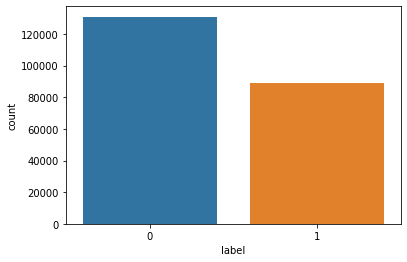

In [10]:
import seaborn as sns
sns.countplot(x='label',data=cancer_labels)

#### the dataset in not highly imbalanced
*There are 130908 normal cases (0) and and 89117 abnormal (cancerous) cases (1)

In [10]:
print('No. of images in training dataset: ', len(os.listdir("/kaggle/input/histopathologic-cancer-detection/train")))
print('No. of images in testing dataset: ', len(os.listdir("/kaggle/input/histopathologic-cancer-detection/test")))

No. of images in training dataset:  220025
No. of images in testing dataset:  57458


In [9]:
train_imgs_orig = os.listdir("/kaggle/input/histopathologic-cancer-detection/train")


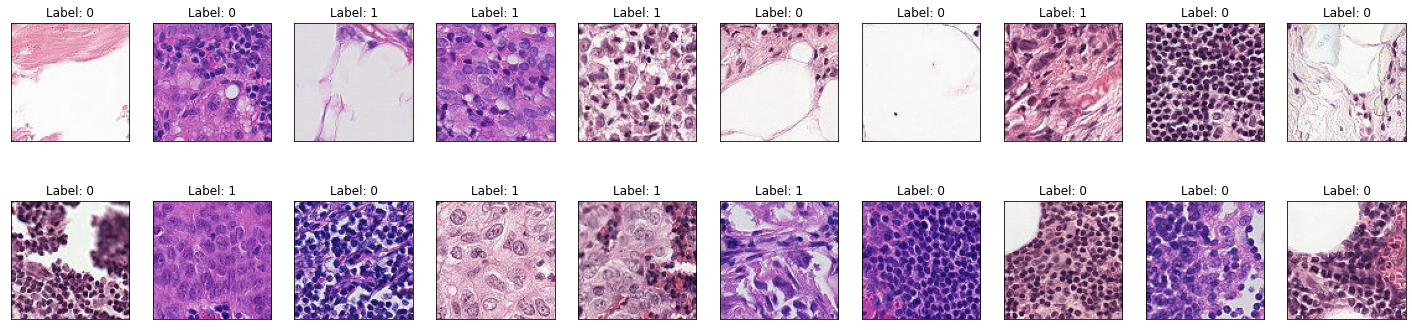

In [12]:
fig = plt.figure(figsize=(25, 6))
for idx, img in enumerate(np.random.choice(train_imgs_orig, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open("/kaggle/input/histopathologic-cancer-detection/train/" + img)
    plt.imshow(im)
    lab = cancer_labels.loc[cancer_labels['id'] == img.split('.')[0], 'label'].values[0]
    ax.set_title(f'Label: {lab}')

In [10]:
data_T_train = T.Compose([
    T.CenterCrop(32),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.ToTensor(),
    ])
data_T_test = T.Compose([
    T.CenterCrop(32),
    T.ToTensor(),
    ])

In [19]:
# dictionary with labels and ids of train data
img_label_dict = {k:v for k, v in zip(cancer_labels['id'], cancer_labels['label'])}

In [20]:
#img_label_dict 

## Build Dataloaders

In [20]:
class LoadCancerDataset(Dataset):
    def __init__(self, data_folder, 
                 transform = T.Compose([T.CenterCrop(32),T.ToTensor()]), dict_labels={}):
        self.data_folder = data_folder
        self.list_image_files = [s for s in os.listdir(data_folder)]
        self.transform = transform
        self.dict_labels = dict_labels
        self.labels = [dict_labels[i.split('.')[0]] for i in self.list_image_files]

    def __len__(self):
        return len(self.list_image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.data_folder, self.list_image_files[idx])
        image = Image.open(img_name)
        image = self.transform(image)
        img_name_short = self.list_image_files[idx].split('.')[0]

        label = self.dict_labels[img_name_short]
        return image, label

In [21]:
class LoadCancerDatasettest(Dataset):
    def __init__(self, data_folder, 
                 transform = T.Compose([T.CenterCrop(32),T.ToTensor()]), dict_labels={}):
        self.data_folder = data_folder
        self.list_image_files = [s for s in os.listdir(data_folder)]
        self.transform = transform
        
    def __len__(self):
        return len(self.list_image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.data_folder, self.list_image_files[idx])
        image = Image.open(img_name)
        image = self.transform(image)
        img_name_short = self.list_image_files[idx].split('.')[0]
        return image

In [22]:
%%time
# Load train data 
train_set = LoadCancerDataset(data_folder='/kaggle/input/histopathologic-cancer-detection/train/', 
                        # datatype='train', 
                        transform=data_T_train, dict_labels=img_label_dict)

CPU times: user 239 ms, sys: 149 ms, total: 388 ms
Wall time: 401 ms


In [16]:
next(iter(train_set))

(tensor([[[0.8941, 0.9412, 0.7843,  ..., 0.6784, 0.6824, 0.7098],
          [0.8353, 0.8392, 0.8235,  ..., 0.5451, 0.5686, 0.4902],
          [0.9333, 0.7882, 0.7412,  ..., 0.5098, 0.5765, 0.7765],
          ...,
          [0.8196, 0.8471, 0.7255,  ..., 0.7059, 0.5529, 0.4941],
          [0.9137, 0.7922, 0.8196,  ..., 0.9882, 0.6392, 0.3176],
          [0.8902, 0.9020, 0.8667,  ..., 0.7412, 0.9490, 0.9529]],
 
         [[0.6471, 0.6863, 0.5216,  ..., 0.3725, 0.3882, 0.4275],
          [0.6000, 0.5922, 0.5686,  ..., 0.2471, 0.2706, 0.1961],
          [0.7020, 0.5529, 0.5059,  ..., 0.2118, 0.2745, 0.4745],
          ...,
          [0.5451, 0.5725, 0.4549,  ..., 0.4392, 0.2863, 0.2196],
          [0.6392, 0.5176, 0.5490,  ..., 0.7294, 0.3765, 0.0549],
          [0.6196, 0.6275, 0.5922,  ..., 0.4824, 0.6863, 0.6902]],
 
         [[0.7608, 0.8039, 0.6431,  ..., 0.5255, 0.5412, 0.5765],
          [0.7098, 0.7059, 0.6863,  ..., 0.3961, 0.4235, 0.3569],
          [0.8118, 0.6549, 0.6078,  ...,

## Split Data into training and validation set

In [23]:
%%time
train_set, val_set = torch.utils.data.random_split(train_set , [200000, 20025])

CPU times: user 18.8 ms, sys: 4.75 ms, total: 23.5 ms
Wall time: 23.6 ms


## Prepare Test Dataset for model input

In [24]:
 test_set = LoadCancerDatasettest(data_folder='/kaggle/input/histopathologic-cancer-detection/test/')

## Prepare Training and validation datasets for batching

In [25]:
batch_size = 256

train_dataloader = DataLoader(train_set, batch_size, num_workers=2, pin_memory=True, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size, num_workers=2, pin_memory=True)
#test_dataloader = DataLoader(test_set, batch_size, num_workers=2, pin_memory=True)

In [26]:
test_dataloader = DataLoader(test_set, 1, num_workers=2, pin_memory=True)

## Prepare Model from scratch

In [21]:
class CNNImageClassifier(pl.LightningModule):

    def __init__(self, learning_rate = 0.001):
        super().__init__()

        self.learning_rate = learning_rate

        self.conv_layer1 = nn.Conv2d(in_channels=3,out_channels=3,kernel_size=3,stride=1,padding=1)
        self.relu1=nn.ReLU()
        self.pool=nn.MaxPool2d(kernel_size=2)
        self.conv_layer2 = nn.Conv2d(in_channels=3,out_channels=6,kernel_size=3,stride=1,padding=1)
        self.relu2=nn.ReLU()
        self.fully_connected_1 =nn.Linear(in_features=16 * 16 * 6,out_features=1000)
        self.fully_connected_2 =nn.Linear(in_features=1000,out_features=500)
        self.fully_connected_3 =nn.Linear(in_features=500,out_features=250)
        self.fully_connected_4 =nn.Linear(in_features=250,out_features=120)
        self.fully_connected_5 =nn.Linear(in_features=120,out_features=60)
        self.fully_connected_6 =nn.Linear(in_features=60,out_features=2)
        self.loss = nn.CrossEntropyLoss()
        self.save_hyperparameters()

    def forward(self, input):
        output=self.conv_layer1(input)
        output=self.relu1(output)
        output=self.pool(output)
        output=self.conv_layer2(output)
        output=self.relu2(output)
        output=output.view(-1, 6*16*16)
        output = self.fully_connected_1(output)
        output = self.fully_connected_2(output)
        output = self.fully_connected_3(output)
        output = self.fully_connected_4(output)
        output = self.fully_connected_5(output)
        output = self.fully_connected_6(output)
        return output

    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs) 
        train_accuracy = accuracy(outputs, targets)
        loss = self.loss(outputs, targets)
        self.log('train_accuracy', train_accuracy, prog_bar=True)
        self.log('train_loss', loss)
        return {"loss":loss, "train_accuracy":train_accuracy}

    def test_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self.forward(inputs)
        test_accuracy = accuracy(outputs, targets)
        loss = self.loss(outputs, targets)
        self.log('test_accuracy', test_accuracy)
        return {"test_loss":loss, "test_accuracy":test_accuracy}

    def configure_optimizers(self):
        params = self.parameters()
        optimizer = optim.Adam(params=params, lr = self.learning_rate)
        return optimizer

    # Calculate accuracy for each batch at a time
    def binary_accuracy(self, outputs, targets):
        _, outputs = torch.max(outputs,1)
        correct_results_sum = (outputs == targets).sum().float()
        acc = correct_results_sum/targets.shape[0]
        return acc

    def predict_step(self, batch, batch_idx ):
        return self(batch)

## Prepare Resent Model - Transfer Learning

In [27]:
class CancerImageClassifier(pl.LightningModule):

    def __init__(self, learning_rate = 0.001):
        super().__init__()

        self.learning_rate = learning_rate
        self.loss = nn.CrossEntropyLoss()
        
        self.pretrain_model = resnet50(pretrained=True)
        self.pretrain_model.eval()
        for param in self.pretrain_model.parameters():
            param.requires_grad = False

        self.pretrain_model.fc = nn.Linear(2048, 2)

    def forward(self, input):
        output=self.pretrain_model(input)
        return output

    def training_step(self, batch, batch_idx):
      inputs, targets = batch
      outputs = self(inputs) 
      preds = torch.argmax(outputs, dim=1)
      train_accuracy = accuracy(preds, targets)
      loss = self.loss(outputs, targets)
      self.log('train_accuracy', train_accuracy, prog_bar=True)
      self.log('train_loss', loss)
      return {"loss":loss, 'train_accuracy': train_accuracy}
      

    def test_step(self, batch, batch_idx):
      inputs, targets = batch
      outputs = self.forward(inputs)
      preds = torch.argmax(outputs, dim=1)
      test_accuracy = accuracy(preds, targets)
      loss = self.loss(outputs, targets)
      # self.log('test_accuracy', test_accuracy, prog_bar=True)
      return {"test_loss":loss, "test_accuracy":test_accuracy}
    
    def test_epoch_end(self, outputs):
      test_outs = []
      for test_out in outputs:
          out = test_out['test_accuracy']
          test_outs.append(out)
      total_test_accuracy = torch.stack(test_outs).mean()
      self.log('total_test_accuracy', total_test_accuracy, on_step=False, on_epoch=True)
      return total_test_accuracy

    def configure_optimizers(self):
      params = self.parameters()
      optimizer = optim.Adam(params=params, lr = self.learning_rate)
      return optimizer

In [28]:
os.mkdir("/kaggle/working/cnn")

In [29]:
ckpt_dir = "/kaggle/working/cnn"
ckpt_callback = pl.callbacks.ModelCheckpoint(every_n_epochs=10)
from pytorch_lightning.callbacks import EarlyStopping
early_stopping = EarlyStopping('val_loss')
#model = CNNImageClassifier()
model = CancerImageClassifier()
trainer = pl.Trainer(default_root_dir=ckpt_dir,
                     accelerator='gpu', 
                     devices=1 if torch.cuda.is_available() else None, 
                     auto_lr_find = True,
                     callbacks=[ckpt_callback],
                     log_every_n_steps=30,
                     max_epochs=15)
trainer.fit(model, train_dataloaders=train_dataloader)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Training: 0it [00:00, ?it/s]

## Evaluate The Model

In [30]:
model.eval()
preds = []
for batch_i, (data, target) in enumerate(val_dataloader):
    data, target = data.cuda(), target.cuda()
    output = model.cuda()(data)

    pr = output.detach().cpu().numpy()
    for i in pr:
        preds.append(i)

In [31]:
len(preds)

20025

In [32]:
preds[:5]

[array([ 1.9207196, -1.1948446], dtype=float32),
 array([0.21352959, 0.18616085], dtype=float32),
 array([-0.3839199 ,  0.60242474], dtype=float32),
 array([ 0.7785907 , -0.92928153], dtype=float32),
 array([0.5086203 , 0.00403684], dtype=float32)]

In [33]:
predictions  = [np.argmax(item) for item in preds]


In [34]:
predictions[:5]

[0, 0, 1, 0, 0]

In [35]:
len(predictions)

20025

In [36]:
len(train_set.dataset.labels)

220025

In [37]:
len(val_set.dataset.list_image_files[-20025:])

20025

In [38]:
val_preds = pd.DataFrame({'imgs': val_set.dataset.list_image_files[-20025:], 'labels':val_set.dataset.labels[-20025:],  'preds': predictions})

In [39]:
val_preds

,imgs,labels,preds
0,177a3cfa748a2e4b016d6b7d26387210a6e8bdd6.tif,0,0
1,2fde3f114976d6c17ad7686bcfd81b8391811c5c.tif,1,0
2,b87144f668e8f1b090f61afac26e7f491286e4a4.tif,0,1
3,5b12300de31de8e0369aed49a94ba4f348056069.tif,0,0
4,33dccd56df7ef9d8ff2148fe94760a20e78ea478.tif,0,0
...,...,...,...
20020,7348cb8441250667a9ed32def21739417d289cc1.tif,1,0
20021,42abd2b045bf906bc512d69b03193a96ba17c390.tif,0,1
20022,31426221d3aaeba3036a079b7e40c63e897780c7.tif,1,1
20023,1732925cb9e16307536bb9cb7d4967829369f53c.tif,1,0


<AxesSubplot:>

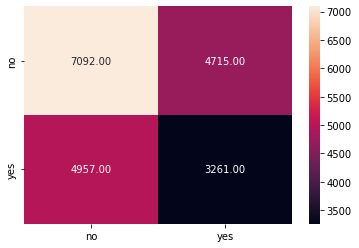

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(val_preds['labels'],val_preds['preds'])
sns.heatmap(cm,annot=True,fmt=".2f",xticklabels=['no','yes'],yticklabels=['no','yes'])

In [42]:
from sklearn.metrics import accuracy_score
print(f"Accuracy Score : {accuracy_score(val_preds['labels'],val_preds['preds'])}")

Accuracy Score : 0.517003745318352


## Make predictions on the test data

In [43]:
final_inference = trainer.predict(model, test_dataloader) 

Predicting: 782it [00:00, ?it/s]

In [44]:
type(final_inference)

list

In [45]:
final_inference[:5]

[tensor([[-2.2275,  1.3727]]),
 tensor([[ 1.1138, -0.8958]]),
 tensor([[-0.4731,  0.5057]]),
 tensor([[-0.6830,  0.3121]]),
 tensor([[0.3683, 0.0165]])]

In [46]:
inference = [ item.detach().cpu().numpy() for item in final_inference]

In [47]:
len(inference)

57458

In [48]:
inference[0]

array([[-2.22751 ,  1.372737]], dtype=float32)

In [49]:
predicted_label = [np.argmax(item) for item in inference]

In [50]:
test_image = os.listdir("/kaggle/input/histopathologic-cancer-detection/test")

In [51]:
len(test_image)

57458

In [52]:
sub = pd.DataFrame({'id':test_image,'label':predicted_label})

In [53]:
sub.head()

,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e.tif,1
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664.tif,0
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb.tif,1
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0.tif,1
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62.tif,0


In [54]:
sub['id'] = sub['id'].apply(lambda x: x.split(".")[0])

In [55]:
sub.head()

,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,1
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,0
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,1
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0,1
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62,0


In [58]:
os.mkdir('/kaggle/working/output')
sub.to_csv('/kaggle/working/output/file2_transfer_learning.csv',index=False)